# Homework (Week 3) -- Biometrics (20 points)

In this homework we train Biometrics Verification model and use some features to increase quality:
1) Train ECAPA-TDNN (10 points)
2) Any contrastive loss (10 points)

Link to download dataset: https://disk.yandex.ru/d/lyhtieYbxQOYqw

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import tqdm.notebook as tqdm
import urllib

import dataset

from IPython.display import clear_output

%matplotlib inline

In [2]:
# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/lyhtieYbxQOYqw'
# final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']
# !wget -O voxceleb.tar.gz "{download_url}"
# !tar -xf voxceleb.tar.gz

### Some model train example

In [3]:
DEVICE = 'cuda' # "cpu" for cpu, also you can use "cuda" for gpu and "mps" for apple silicon
DATADIR = 'data'
FEATS = 80
LOADER_WORKERS = 0

In [4]:
import datasets
transform = torchaudio.transforms.MFCC(n_mfcc=FEATS) # You can try some other transformations here
trainset = datasets.Dataset(os.path.join(DATADIR, 'voxceleb_train'), transform)
testset = datasets.Dataset(os.path.join(DATADIR, 'voxceleb_test'), transform)
test_targets = pd.read_csv(os.path.join(DATADIR, 'target.csv')).values.tolist()

/opt/conda/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


### Models

In [5]:
class Model(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden: int, kernel: int = 7, sride: int = 2):
        super().__init__()
        self._emb = nn.Sequential(
            nn.Conv1d(input_shape, hidden, kernel, stride=sride),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel, stride=sride),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel, stride=sride),
            nn.AdaptiveMaxPool1d(1),
        )
        self._final = nn.Sequential(
            nn.Linear(hidden, output_shape),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, X) -> tuple[torch.Tensor, torch.Tensor]:
        emb = self._emb(X).squeeze(2)
        return self._final(emb), emb

### Metrics

Cosine similarity:
$CS(a, b) = \frac{<a, b>}{\|a\| \|b\|}$

In [6]:
def cosine_similarity(a, b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

Here is O(N log N) algorithm for find best_eer:
1) Sort prediction by probability
2) Going through items and recalculating far and frr

In [7]:
def best_eer(data):
    full = sorted(data, key=lambda x: (x[0], -x[1]))
    pos = len([item for item in full if item[1] == 1])
    neg = len(full) - pos
    cur_pos = pos
    cur_neg = 0
    best_eer = 1
    for _, label in full:
        if label == 1:
            cur_pos -= 1
        else:
            cur_neg += 1
        cur_eer = max((pos - cur_pos) / pos, (neg - cur_neg) / neg)
        best_eer = min(best_eer, cur_eer)
    return best_eer

### Train

In [8]:
!pip cache purge

Files removed: 0


In [31]:
def train_stage(model, opt, batch_size: int = 256):
    loader = torch_data.DataLoader(
        trainset,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=datasets.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    loss_sum = 0.0
    batches = 0
    for X, Y, _ in tqdm.tqdm(loader):
        logits, _ = model.forward(X.to(DEVICE), Y.to(DEVICE))
        loss = F.nll_loss(logits, Y.to(DEVICE))
        loss_sum += loss.item()
        batches += 1
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss_sum / batches

In [10]:
def calc_eval_score(model: nn.Module, batch_size: int = 256):
    loader = torch_data.DataLoader(
        testset,
        batch_size=batch_size,
        collate_fn=datasets.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    items = {}
    target_scores = []
    with torch.no_grad():
        for X, _, pathes in tqdm.tqdm(loader):
            _, embds = model.forward(X.to(DEVICE))
            embds = embds.cpu().data.numpy().reshape(X.shape[0], -1)
            for embd, path in zip(embds, pathes):
                items[path] = embd
    for item1, item2, target in test_targets:
        target_scores.append((cosine_similarity(items[item1], items[item2]), target))
    return best_eer(target_scores)

In [11]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.1


In [46]:
def train(
    model: nn.Module,
    opt,
    batch_size: int = 256,
    epochs: int = 20,
    train_fun = train_stage,
    train_kwargs = {},
):
    train_losses = []
    eval_scores = []
    for epoch in range(epochs):
        model.train()
        train_losses.append(train_fun(model, opt, batch_size=batch_size))
        model.eval()
        eval_scores.append(calc_eval_score(model, batch_size=batch_size))
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train CE loss')
        axis[1].plot(np.arange(1, epoch + 2), eval_scores, label='eval')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='EER')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}. Train loss {train_losses[-1]}. Eval score {eval_scores[-1]}')

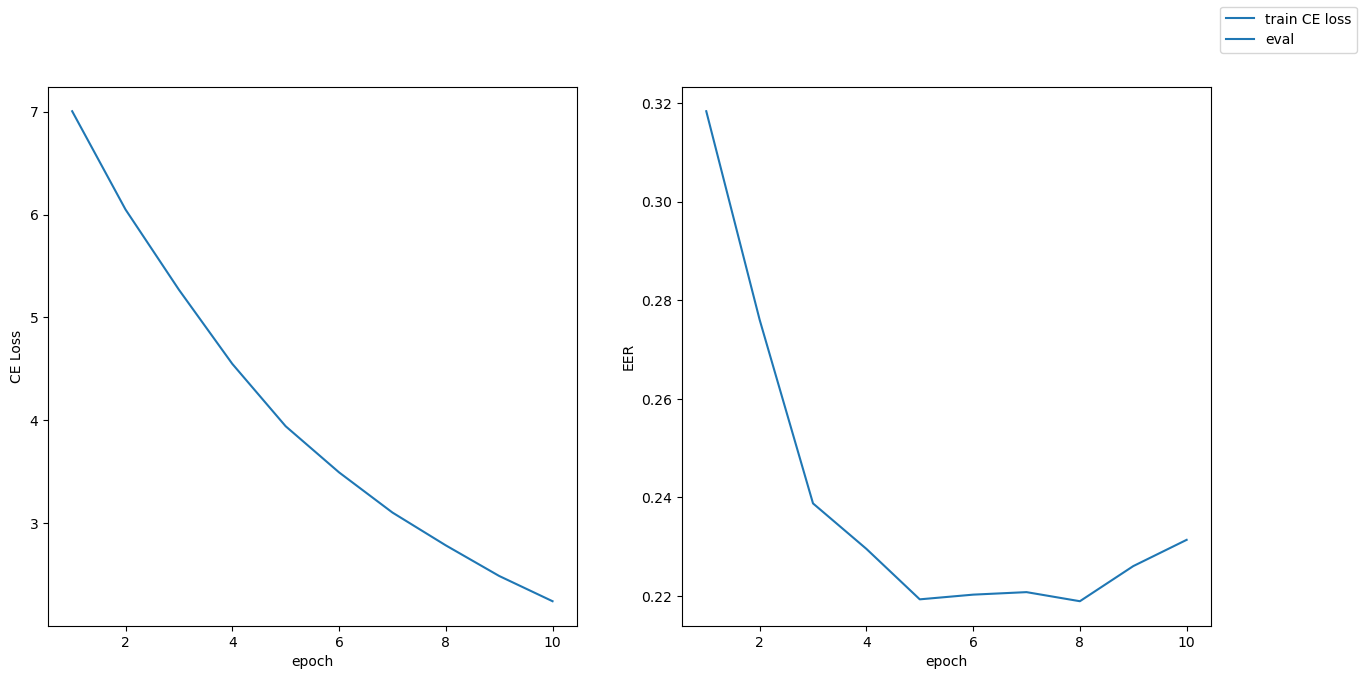

Epoch 10. Train loss 2.2411774927715085. Eval score 0.23140548048996085


In [13]:
model = Model(FEATS, trainset.speakers(), 128).to(DEVICE)
opt = optim.Adam(model.parameters())
train(model, opt)

### ECAPA TDNN (10 points)

Paper: https://arxiv.org/pdf/2005.07143.pdf

Papers for ECAPA parts:
- SE-Blocks - https://arxiv.org/pdf/1709.01507.pdf
- Res2Net - https://arxiv.org/pdf/1904.01169.pdf
- Attentive Stats Pooling - https://arxiv.org/pdf/1803.10963.pdf
- AAM Softmax - https://arxiv.org/pdf/1906.07317.pdf

Also you can optionally add other settings for paper:
- SpecAug
- Weight decay for optimizer
- LR scheduler

In [22]:
class SEBlock(nn.Module):
    def __init__(self, input_shape: int, reduction: int = 8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_shape, input_shape // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(input_shape // reduction, input_shape),
            nn.Sigmoid()
        )

    def __call__(self, X):
        b, c, t = X.size()
       
        y = self.avg_pool(X).view(b, c)
        
        y = self.fc(y).view(b, c, 1)
       
        return X * y

In [23]:
class Res2Net(nn.Module):
    def __init__(self, hidden: int, dilation: int, scale: int = 8):
        super().__init__()
        self.hidden = hidden
        self.scale = scale
       
        width = hidden // scale
        
        self.convs = nn.ModuleList([
            nn.Conv1d(width, width, kernel_size=3, dilation=dilation, padding=dilation) 
            for _ in range(scale - 1)
        ])

    def __call__(self, X):
        
        chunks = torch.chunk(X, self.scale, dim=1)
        y = []
        prev = None
        
        for i, chunk in enumerate(chunks):
            if i == 0:
                
                out = chunk
            else:
                
                if prev is not None:
                    chunk = chunk + prev
                out = self.convs[i-1](chunk)
            
            y.append(out)
            prev = out
            
        return torch.cat(y, dim=1)

In [24]:
class EcapaBlock(nn.Module):
    def __init__(self, hidden: int, dilation: int, scale: int = 8):
        super().__init__()
        # 1x1 
        self.conv1 = nn.Conv1d(hidden, hidden, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(hidden)
        self.relu1 = nn.ReLU()
        
        # Res2Net layer 
        self.res2net = Res2Net(hidden, dilation, scale)
        self.bn2 = nn.BatchNorm1d(hidden)
        self.relu2 = nn.ReLU()
        
        # 1x1 Conv 
        self.conv2 = nn.Conv1d(hidden, hidden, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(hidden)
        self.relu3 = nn.ReLU()
        
        self.se = SEBlock(hidden)

    def __call__(self, X):
        residual = X
        
        x = self.conv1(X)
        x = self.relu1(self.bn1(x))
        
        x = self.res2net(x)
        x = self.relu2(self.bn2(x))
        
        x = self.conv2(x)
        x = self.relu3(self.bn3(x))
        
        x = self.se(x)
        
        return x + residual

In [25]:
class AttentiveStatsPooling(nn.Module):
    def __init__(self, input_shape: int, hidden: int = 128):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Conv1d(input_shape, hidden, kernel_size=1),
            nn.Tanh(),
            nn.Conv1d(hidden, input_shape, kernel_size=1),
            nn.Softmax(dim=2)
        )

    def __call__(self, X):
        
        w = self.attention(X)
        
        mu = torch.sum(X * w, dim=2)
        
        rh = torch.sqrt(torch.sum(w * (X - mu.unsqueeze(2))**2, dim=2) + 1e-6)
        
        return torch.cat((mu, rh), dim=1)

In [26]:
import math

class AAMSoftmax(nn.Module):
    def __init__(self, input_shape, n_class, margin=0.2, scale=30):
        super().__init__()
        self.m = margin
        self.s = scale
        self.weight = nn.Parameter(torch.FloatTensor(n_class, input_shape))
        nn.init.xavier_uniform_(self.weight)
        
        self.cos_m = math.cos(self.m)
        self.sin_m = math.sin(self.m)
        self.th = math.cos(math.pi - self.m)
        self.mm = math.sin(math.pi - self.m) * self.m

    def forward(self, X, label=None):
        cosine = F.linear(F.normalize(X), F.normalize(self.weight))
        
        if label is None:
            return cosine
            
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        
        one_hot = torch.zeros(cosine.size(), device=X.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        
        return output

In [27]:
class EcapaTDNN(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden: int = 128):
        super().__init__()
        
        self.layer1 = nn.Conv1d(input_shape, hidden, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden)
        
        self.layer2 = EcapaBlock(hidden, dilation=2, scale=8)
        self.layer3 = EcapaBlock(hidden, dilation=3, scale=8)
        self.layer4 = EcapaBlock(hidden, dilation=4, scale=8)
        self.layer5 = nn.Conv1d(3 * hidden, 1536, kernel_size=1)
        
        self.pooling = AttentiveStatsPooling(1536, 128)
        self.bn5 = nn.BatchNorm1d(3072)
        
        self.linear = nn.Linear(3072, 256)
        self.bn6 = nn.BatchNorm1d(256)
        
        self.classifier = AAMSoftmax(256, output_shape, margin=0.2, scale=30)

    def forward(self, X, label=None):
        x1 = self.layer1(X)
        x1 = self.relu(self.bn1(x1))
        
        x2 = self.layer2(x1)
        x3 = self.layer3(x2 + x1)
        x4 = self.layer4(x3 + x2)
    
        x = torch.cat((x2, x3, x4), dim=1)
        
        # Bottleneck and Pooling
        x = self.layer5(x)
        x = self.pooling(x)
        x = self.bn5(x)
        
        embedding = self.linear(x)
        embedding = self.bn6(embedding)
        
        if self.training and label is not None:
             logits = self.classifier(embedding, label)
             return logits, embedding
        
        return self.classifier(embedding), embedding

Train ECAPA model, at this point you can archive stable score (for several consecutive epochs) near 0.08 EER.

You can train ECAPA with hidden size 256 to increase speed

In [30]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

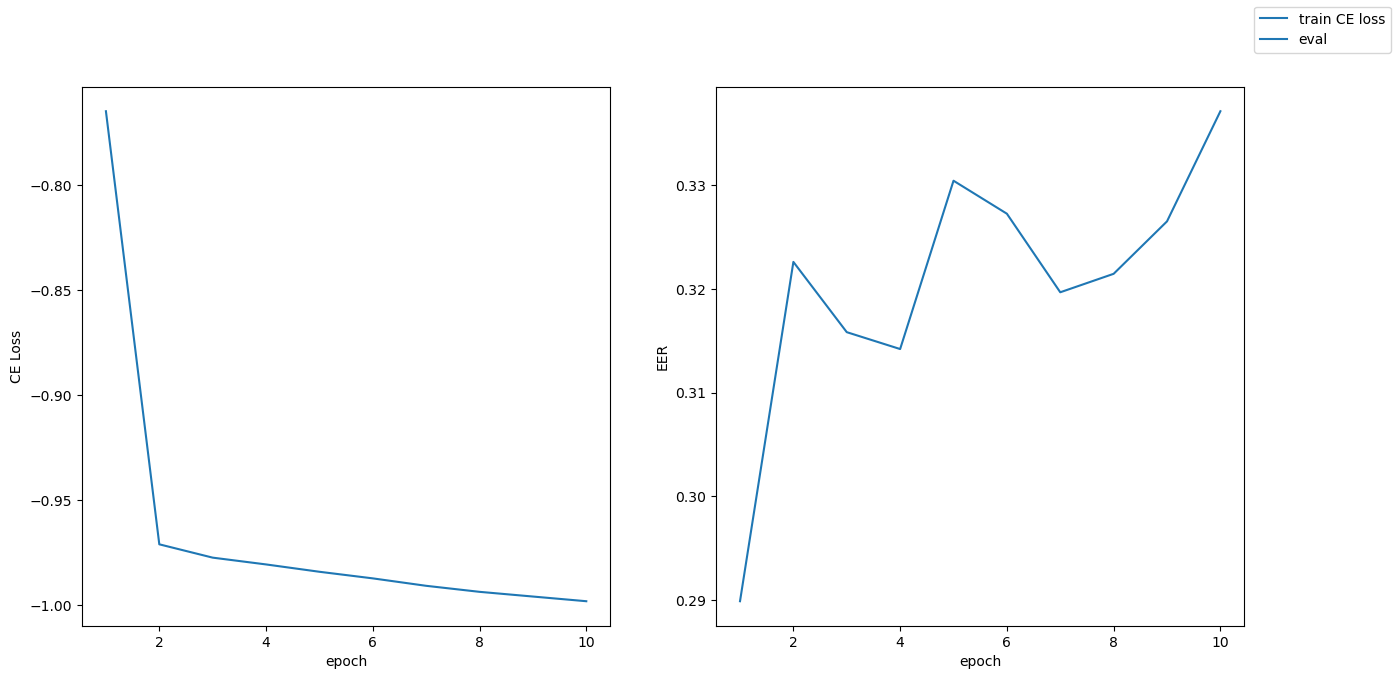

Epoch 10. Train loss -0.9981121641847323. Eval score 0.33710064402070966


In [32]:
model = EcapaTDNN(FEATS, trainset.speakers(), 128).to(DEVICE)
opt = optim.Adam(model.parameters())
train(model, opt, batch_size=64)

In [33]:
# Save model to preserve results before uptraining experiments
torch.save(model, 'model.pt')

### Contrastive losses (10 points)

You can use anyone constrative loss.
Good article with contrastive losses https://lilianweng.github.io/posts/2021-05-31-contrastive/

Base losses:
- contrastive
- triplet -- it gives a better quality usually
- lifted structured loss -- better batch data utilization

The main problem with contrastive loss is the positive pairs sampler.
This is because a large number of classes provided only once per batch
in case of large number of classes in the dataset.

In [37]:
import random

class PositivePairsSampler(torch.utils.data.Sampler):
    def __init__(self, speakers: list[int], batch_size: int):
        self.batch_size = batch_size
        self.speakers = np.array(speakers)
        self.unique_speakers = np.unique(self.speakers)
        
        # Pre-calculate indices for each speaker
        self.speaker_indices = {
            s: np.where(self.speakers == s)[0] for s in self.unique_speakers
        }
        
    def __len__(self):
        # Approximate number of batches
        return len(self.speakers) // self.batch_size

    def __iter__(self):
        # We need batch_size // 2 speakers, providing 2 samples each
        n_speakers_per_batch = self.batch_size // 2
        
        for _ in range(len(self)):
            batch_indices = []
            # Randomly select speakers for this batch
            chosen_speakers = np.random.choice(self.unique_speakers, n_speakers_per_batch, replace=False)
            
            for speaker in chosen_speakers:
                # Get all indices for this speaker
                indices = self.speaker_indices[speaker]
                
                # If speaker has less than 2 samples, handle gracefully (e.g. use replacement)
                replace = len(indices) < 2
                
                # Select 2 samples
                selected = np.random.choice(indices, 2, replace=replace)
                batch_indices.extend(selected)
            
            # Shuffle the batch so the pairs aren't always adjacent (optional but good practice)
            # np.random.shuffle(batch_indices) 
            yield batch_indices

In [44]:
def contrastive_train_stage(model, opt, batch_size: int = 64):
    # Use the extracted train_labels here
    sampler = PositivePairsSampler(train_labels, batch_size) 
    
    loader = torch_data.DataLoader(
        trainset,
        # Fixed typo: 'dataset.collate_fn', not 'datasets.collate_fn'
        collate_fn=datasets.collate_fn, 
        num_workers=LOADER_WORKERS,
        batch_sampler=sampler
    )
    
    # Triplet Loss definition
    triplet_loss_fn = nn.TripletMarginLoss(margin=0.2, p=2)
    
    loss_sum = 0.0
    batches = 0
    
    for X, Y, _ in tqdm.tqdm(loader):
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
        
        logits, embeddings = model.forward(X, Y)
        
        # 1. AAM Softmax Loss
        ce_loss = F.cross_entropy(logits, Y)
        
        # 2. Triplet Loss
        anchors = embeddings[0::2]
        positives = embeddings[1::2]
        # Simple negative mining: roll positives by 1
        negatives = torch.roll(positives, shifts=1, dims=0)
        
        tri_loss = triplet_loss_fn(anchors, positives, negatives)
        
        loss = ce_loss + tri_loss
        
        loss_sum += loss.item()
        batches += 1
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss_sum / batches

Train model with contrastive loss here. At this point you can archive EER near 0.06-0.07 (it should be at least on 0.005 to 0.01 better than before)

In [43]:
def get_all_labels(ds):
    # Try standard attributes first
    if hasattr(ds, 'labels'): return ds.labels
    if hasattr(ds, 'targets'): return ds.targets
    
    # Try attributes common in this specific homework template
    if hasattr(ds, 'index'): return [item[1] for item in ds.index]
    if hasattr(ds, 'data'): return [item[1] for item in ds.data]
    if hasattr(ds, 'items'): return [item[1] for item in ds.items]
    
    # Fallback: Iterate through dataset (slow but guaranteed to work)
    print("Attribute not found. Extracting labels manually...")
    labels = []
    for i in tqdm.tqdm(range(len(ds))):
        # dataset[i] returns (waveform, label, path)
        labels.append(ds[i][1])
    return labels

# Generate the labels list once
train_labels = get_all_labels(trainset)
print(f"Extracted {len(train_labels)} labels.")

Attribute not found. Extracting labels manually...


  0%|          | 0/67785 [00:00<?, ?it/s]

Extracted 67785 labels.


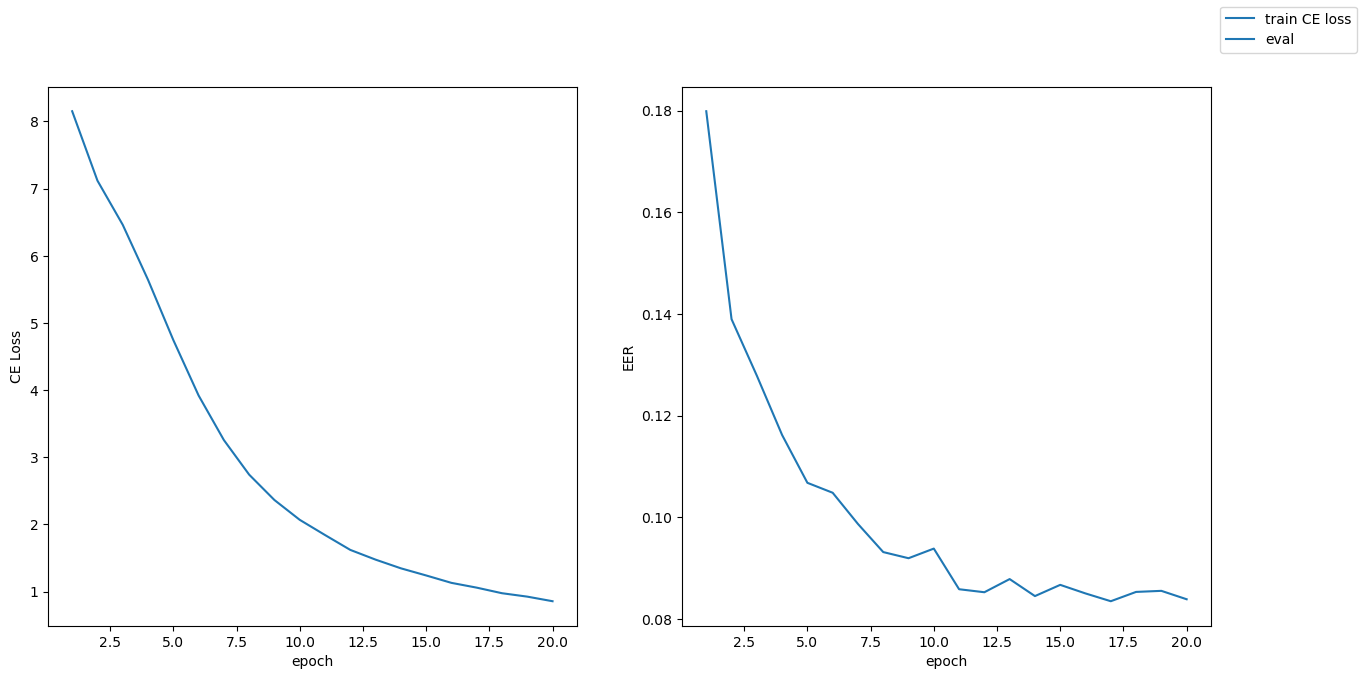

Epoch 20. Train loss 0.8565888565255292. Eval score 0.08385784220230148


In [47]:
# Fix the torch.load warning and run training
model = torch.load('model.pt', weights_only=False).to(DEVICE)
opt = optim.Adam(model.parameters())

# Start training
train(model, opt, batch_size=64, train_fun=contrastive_train_stage)